# Automatic tagging 

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import os
import pickle as pkl
import re
import string

In [0]:
# for data processing

import numpy as np
import pandas as pd 
import tqdm

In [4]:
# for text 

import nltk
import re 
from nltk import tokenize
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemm = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# for analysis

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# For modeling

from sklearn import neighbors
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [0]:
# For visuals

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [7]:
! pip install version_information

In [8]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,numpy,sklearn,nltk, seaborn, matplotlib

Software versions
Python 3.6.8 64bit [GCC 8.3.0]
IPython 5.5.0
OS Linux 4.14.137+ x86_64 with Ubuntu 18.04 bionic
pandas 0.25.3
numpy 1.17.4
sklearn 0.21.3
nltk 3.2.5
seaborn 0.9.0
matplotlib 3.1.1
Wed Nov 27 15:20:38 2019 UTC

# 2)- Reading Dataset

Thanks to PyData 2018: Gilbert Francois Talk

In [9]:
df= pd.read_pickle('messages-cls.pkl')
df.shape

(1719, 5)

In [10]:
df.head()

,ts,user,text,class,key
0,1.503303e+09,Balaemar,I have to pick up my car from the garage tomorrow. I have to leave at 15:45 on Thursday.,1,1503303350U035FRUCY
1,1.503302e+09,Ragaenys,"I won’t be here tomorrow, one day vacation",2,1503301710U4A2FRAQ4
2,1.503296e+09,Myke,"Missed connection in Zurich. Will be about 5-10 mins late in the office, so will miss the weekly today.",1,1503296123U0MGNKETU
3,1.503260e+09,Drevyn,Enjoy!,8,1503259722U035B8PRU
4,1.503258e+09,Gaelralis,I am away for 2 weeks in iceland :flag-is:,2,1503258060U0HLAK1T6


In [11]:
df.tail()

,ts,user,text,class,key
1717,1.462269e+09,Overton,<@U0PSDKXHR|jabbah> has joined the channel,8,1462269461U0PSDKXHR
1718,1.462269e+09,Balaemar,<@U035FRUCY|miamia> has joined the channel,8,1462269461U035FRUCY
1719,1.462269e+09,Eliar,<@U0A8NPHRD|joe> has joined the channel,8,1462269366U0A8NPHRD
1720,1.462268e+09,Caenraenos,"<@U035AASB8|Fisher> set the channel topic: home office, lateness, general absence updates",8,1462267520U035AASB8
1721,1.462267e+09,Caenraenos,<@U035AASB8|Fisher> has joined the channel,8,1462267404U035AASB8


In [12]:
df['class'].unique()

array([1, 2, 8, 3, 6, 4, 5, 7])

# Class	Description
- 1	Too late, away during office hours or early leave
- 2	Holidays or scheduled free days
- 3	Home Office
 -4	Medical appointment
- 5	Ill, without consulting a medical
- 6	Work related absence (at client, conference)
- 7	In office announcement
- 8	Miscellanious

In [0]:
dict_classes = {
    1: 'late/early',
    2: 'holidays',
    3: 'home office',
    4: 'med app',
    5: 'ill',
    6: 'business',
    7: 'in office',
    8: 'miscellanious'
}

In [14]:
df['class'].value_counts()

1    517
3    423
8    223
2    173
6    142
4    134
5     74
7     33
Name: class, dtype: int64

In [15]:
df.isnull().sum()

ts       0
user     0
text     0
class    0
key      0
dtype: int64

# 3)- Making Helper Functions

In [0]:
stemmer = nltk.PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def lemma(doc):
    return [lemm.lemmatize(w) for w in analyzer(doc)]


def no_lemma(doc):
    return [w for w in analyzer(doc)]


def stemmed(doc):
    return [stemmer.stem(w) for w in analyzer(doc)]


def no_stemmed(doc):
    return [w for w in analyzer(doc)]


def mask_integers(s):
    return re.sub(r'\d+', '_INT', s)


def mask_times(text):
    """
    Replaces times written like 12:50, 1PM, 4:15am, etc to _time token.
    :param    text    Input text
    :return           Output text with replaced times.
    """
    re_time1 = '\d{1,2}[:.]\d{2}(?:am|pm|AM|PM)'
    re_time2 = '\d{1,2}[:.]\d{2}'
    re_time3 = '\d{1,2}(?:am|pm|AM|PM)'
    rec_time = re.compile(re_time1 + '|' + re_time2 + '|' + re_time3)
    return re.sub(rec_time, '_TIME', text)


def mask_emojis(text):
    """
    Replaces all different emojis to _emoji token.
    :param    text    Input text
    :return           Output text with replaced emojis.    
    """
    re_icons = ':[a-z-_]*:'
    re_ldsd = '\<(.*?)\>'
    rec_icons = re.compile(re_icons + "|" + re_ldsd)
    return re.sub(rec_icons, '_EMOJI', text)


def mask_all(text):
    text = mask_times(text)
    text = mask_emojis(text)
    text = mask_integers(text)
    return text


def train_and_test(steps, X_train, X_test, y_train, y_test):
    """
    Trains and tests the pipeline with the given steps. 
    :param steps:       List of operations inside the pipeline.
    :param X_train:     Training data
    :param X_test:      Training labels
    :param y_train:     Testing data
    :param y_test:      Testing labels
    :return:            Trained model
    """
    pipeline = Pipeline(steps)
    folds = 5
    xval_score = cross_val_score(pipeline, X_train, y_train, cv=folds, n_jobs=-1)
    
    xv_min = np.min(xval_score)
    xv_max = np.max(xval_score)
    xv_mean = np.mean(xval_score)
    xv_std = np.std(xval_score)
    print('{} fold Cross Validation Score: <{:.2f}, {:.2f}>; µ={:.2f}'.format(folds, xv_min, xv_max, xv_mean))
    pipeline = pipeline.fit(X_train, y_train)
    print('Score on test set: {:.2f}'.format(pipeline.score(X_test, y_test)))
    return pipeline


def tag_message(pipeline, message):
    y_pred = pipeline.predict([message])[0]
    print('{:>20} | {}'.format(dict_classes[y_pred], message))

# 4)- Data Preprocessing

In [17]:
# Remove all rows which have no annotation
samples = df.dropna()

# Convert the classification column to unsigned int, in case it is stored as string
samples['class'] = samples.loc[:, 'class'].astype(np.uint8).values

X = samples['text']
y = samples['class']

print('[.] Number of training samples: {}'.format(len(X)))

[.] Number of training samples: 1719


In [18]:
samples.shape

(1719, 5)

### 4a)- Train-Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1375,)
(344,)
(1375,)
(344,)


# 5)- Buidling NLP pipeline

https://buhrmann.github.io/sklearn-pipelines.html

In [21]:
steps = [('vectorizer', CountVectorizer()),
         ('classifier', LinearSVC(random_state=1))]
pipeline1 = train_and_test(steps, X_train, X_test, y_train, y_test) # steps we defined as 5 for saving computing

5 fold Cross Validation Score: <0.78, 0.83>; µ=0.81
Score on test set: 0.82


A very basic NLP Pipeline with model SVC and count vectorizer gives pretty good results. Let's see if we could get any better of it. 

### 5a)- predict results

In [22]:
y_pred = pipeline1.predict(X_test)
y_pred[:5]

array([3, 3, 1, 1, 2], dtype=uint8)

In [23]:
# check accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred=y_pred, y_true=y_test)
accuracy

0.8197674418604651

### 5b)- Confusion Matrix

In [24]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
cm

array([[89,  0,  4,  3,  0,  1,  1,  2],
       [ 5, 28,  1,  0,  0,  0,  1,  0],
       [ 6,  3, 79,  2,  1,  1,  2,  1],
       [ 3,  0,  3, 18,  1,  1,  0,  0],
       [ 1,  2,  2,  0,  6,  0,  0,  0],
       [ 1,  2,  1,  0,  0, 25,  1,  0],
       [ 4,  0,  0,  0,  0,  0,  1,  1],
       [ 2,  0,  2,  0,  0,  0,  1, 36]])

In [25]:
! pip install scikit-plot

<Figure size 432x288 with 0 Axes>

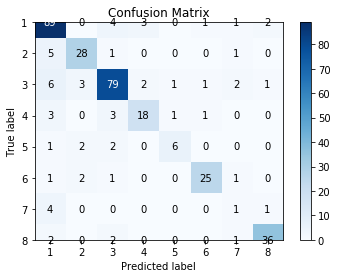

In [26]:
import scikitplot as skplt
plt.figure()
skplt.metrics.plot_confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.show()

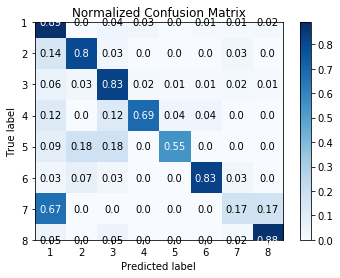

In [27]:
skplt.metrics.plot_confusion_matrix(y_pred=y_pred, y_true=y_test, normalize=True)

### 5c)- Classification Report

In [28]:
from sklearn.metrics import classification_report
report = classification_report(y_pred=y_pred, y_true=y_test)
print(report)

              precision    recall  f1-score   support

           1       0.80      0.89      0.84       100
           2       0.80      0.80      0.80        35
           3       0.86      0.83      0.84        95
           4       0.78      0.69      0.73        26
           5       0.75      0.55      0.63        11
           6       0.89      0.83      0.86        30
           7       0.14      0.17      0.15         6
           8       0.90      0.88      0.89        41

    accuracy                           0.82       344
   macro avg       0.74      0.70      0.72       344
weighted avg       0.82      0.82      0.82       344



### 5d)- Checking params

In [29]:
pipeline1.get_params()

{'classifier': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
           verbose=0),
 'classifier__C': 1.0,
 'classifier__class_weight': None,
 'classifier__dual': True,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__loss': 'squared_hinge',
 'classifier__max_iter': 1000,
 'classifier__multi_class': 'ovr',
 'classifier__penalty': 'l2',
 'classifier__random_state': 1,
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'memory': None,
 'steps': [('vectorizer',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_

All objects in the pipeline are stored in a dictonary

In [30]:
# suppose if we want to transform only a document to a vector
vectorizer = pipeline1.get_params()['vectorizer']
vectorizer.transform(['A new document']).toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

### 5e)- Check out of sample data

In [31]:
pipeline = pipeline1

tag_message(pipeline, 'My alarm clock was not set properly. I come to the office asap.')
tag_message(pipeline, 'It is my scheduled day off, see you on Tuesday.')
tag_message(pipeline, 'Not feeling well today, I stay home and work from here.')
tag_message(pipeline, 'I work at home on Tuesday.')
tag_message(pipeline, 'This morning I have a meeting at SPS.')
tag_message(pipeline, 'I\'m off, see you tomorrow.')
tag_message(pipeline, 'get well soon!')
tag_message(pipeline, 'I\'m away for a long lunch between 12:00 and 15:30')
tag_message(pipeline, 'I\'ve an appointment at 12:00 at the physiotherapy.')

          late/early | My alarm clock was not set properly. I come to the office asap.
            holidays | It is my scheduled day off, see you on Tuesday.
                 ill | Not feeling well today, I stay home and work from here.
         home office | I work at home on Tuesday.
            business | This morning I have a meeting at SPS.
            holidays | I'm off, see you tomorrow.
       miscellanious | get well soon!
          late/early | I'm away for a long lunch between 12:00 and 15:30
             med app | I've an appointment at 12:00 at the physiotherapy.


# 6)- Building more pipelines

To improve results

### Add TF-IDF transformer 

In [32]:
steps = [('vectorizer', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('classifier', LinearSVC(random_state=1))]
pipeline2 = train_and_test(steps, X_train, X_test, y_train, y_test)

5 fold Cross Validation Score: <0.83, 0.85>; µ=0.83
Score on test set: 0.84


### Add lemmatization

In [33]:
steps = [('vectorizer', CountVectorizer(analyzer=lemma)),
         ('tfidf', TfidfTransformer()),
         ('classifier', LinearSVC(random_state=1))]
pipeline3 = train_and_test(steps, X_train, X_test, y_train, y_test)

5 fold Cross Validation Score: <0.82, 0.84>; µ=0.83
Score on test set: 0.84


### Check lemmatization vs stemming

In [34]:
steps = [('vectorizer', CountVectorizer(analyzer=stemmed)),
         ('tfidf', TfidfTransformer()),
         ('classifier', LinearSVC(random_state=1))]
pipeline3 = train_and_test(steps, X_train, X_test, y_train, y_test)

5 fold Cross Validation Score: <0.82, 0.86>; µ=0.84
Score on test set: 0.85


Though I prefer lemmatization more but, stemming is actually giving improved results. For that only reason, we shall use "stemmed"

### Add stop-words

In [35]:
steps = [('vectorizer', CountVectorizer(analyzer=stemmed, 
                                        stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('classifier', LinearSVC(random_state=1))]
pipeline4 = train_and_test(steps, X_train, X_test, y_train, y_test)

5 fold Cross Validation Score: <0.82, 0.86>; µ=0.84
Score on test set: 0.85


### Add n-gram with one token but, two words combination

In [36]:
steps = [('vectorizer', CountVectorizer(ngram_range=(1, 2))),
         ('tfidf', TfidfTransformer()),
         ('classifier', LinearSVC(random_state=1))]
pipeline5 = train_and_test(steps, X_train, X_test, y_train, y_test)

5 fold Cross Validation Score: <0.79, 0.84>; µ=0.82
Score on test set: 0.85


### Add n-gram with one token but, three words combination

In [37]:
steps = [('vectorizer', CountVectorizer(ngram_range=(1, 3))),
         ('tfidf', TfidfTransformer()),
         ('classifier', LinearSVC(random_state=1))]
pipeline6 = train_and_test(steps, X_train, X_test, y_train, y_test)

5 fold Cross Validation Score: <0.78, 0.83>; µ=0.81
Score on test set: 0.86


### Finally, sum up all good parameters of NLP pipeline

In [38]:
steps = [('vectorizer', CountVectorizer(preprocessor=mask_all,  # it contains times, emoji,integers
                                        analyzer=stemmed, 
                                        stop_words='english', 
                                        ngram_range=(1, 3))),
         ('tfidf', TfidfTransformer()),
         ('classifier', LinearSVC(random_state=1))]
pipeline7 = train_and_test(steps, X_train, X_test, y_train, y_test)

5 fold Cross Validation Score: <0.82, 0.86>; µ=0.84
Score on test set: 0.85


# 7)- One vs Rest Classifiers

In [39]:
#Let's train 8 classifiers: One vs Rest

enc = OneHotEncoder()
ym_train = enc.fit_transform(np.array(y_train.tolist()).reshape(-1,1))
ym_test = enc.transform(np.array(y_test.tolist()).reshape(-1,1))

steps = [('vectorizer', CountVectorizer(analyzer=stemmed, 
                                        stop_words='english', 
                                        preprocessor=mask_all)),
         ('transformer', TfidfTransformer()),
         ('classifier', OneVsRestClassifier(LinearSVC(random_state=1, multi_class='ovr')))]
pipeline8 = train_and_test(steps, X_train, X_test, ym_train, ym_test)

5 fold Cross Validation Score: <0.68, 0.76>; µ=0.72
Score on test set: 0.74


Lower than previous all.

In [40]:
steps = [('vectorizer', CountVectorizer(ngram_range=(1,3), 
                                        analyzer=stemmed, 
                                        stop_words='english', 
                                        preprocessor=mask_all)),
         ('transformer', TfidfTransformer()),
         ('classifier', OneVsOneClassifier(LinearSVC(random_state=1, multi_class='ovr')))]
pipeline9 = train_and_test(steps, X_train, X_test, y_train, y_test)

5 fold Cross Validation Score: <0.83, 0.84>; µ=0.83
Score on test set: 0.82


Better yet we have pipeline 6 giving better results. We still check results with pipeline 9.

In [41]:
y_pred = pipeline9.predict(X_test)

print(accuracy_score(y_pred=y_pred, y_true=y_test))

0.8226744186046512


In [42]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           1       0.76      0.91      0.83       100
           2       0.80      0.80      0.80        35
           3       0.87      0.82      0.84        95
           4       0.89      0.65      0.76        26
           5       0.71      0.45      0.56        11
           6       0.92      0.77      0.84        30
           7       0.50      0.33      0.40         6
           8       0.89      0.95      0.92        41

    accuracy                           0.82       344
   macro avg       0.79      0.71      0.74       344
weighted avg       0.83      0.82      0.82       344



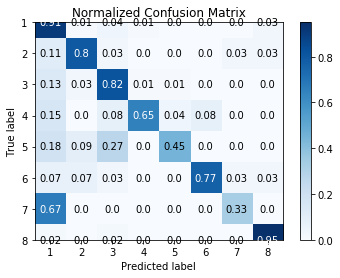

In [43]:
skplt.metrics.plot_confusion_matrix(y_pred=y_pred, y_true=y_test, normalize=True)

# 8)- Grid Search

In [44]:
%%time

steps = [('vectorizer', CountVectorizer()),
         ('transformer', TfidfTransformer()),
         ('classifier', SVC(kernel='linear', random_state=1))]
pipeline10 = Pipeline(steps)

params = {
    'vectorizer__tokenizer': [None, nltk.tokenize.word_tokenize],
    'vectorizer__analyzer': ['word', stemmed, lemma],
    'vectorizer__stop_words': [None, nltk.corpus.stopwords.words('english'), 'english'],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)],
    'vectorizer__preprocessor': [None, mask_all, mask_integers, mask_times, mask_emojis],
    'classifier__C': np.logspace(-2, 2, 5),
    'classifier__gamma': np.logspace(-5, 3, 9)
}

gs = GridSearchCV(pipeline10, params, n_jobs=-1,verbose=5)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 16200 candidates, totalling 48600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 2174 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 3038 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 3524 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | ela

CPU times: user 6min 12s, sys: 6.76 s, total: 6min 19s
Wall time: 4h 26s


In [45]:
print(gs.best_params_)

{'classifier__C': 1.0, 'classifier__gamma': 1e-05, 'vectorizer__analyzer': <function stemmed at 0x7fa63c8a5bf8>, 'vectorizer__ngram_range': (1, 1), 'vectorizer__preprocessor': None, 'vectorizer__stop_words': None, 'vectorizer__tokenizer': None}


In [0]:
y_pred = gs.predict(X_test)

In [47]:
print('Score on the test set: {:.2f}'.format(gs.score(X_test, y_test)))

Score on the test set: 0.82


In [48]:
print('Score on the test set: {:.2f}'.format(accuracy_score(y_pred=y_pred, y_true=y_test)))

Score on the test set: 0.82


In [49]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           1       0.76      0.89      0.82       100
           2       0.80      0.80      0.80        35
           3       0.86      0.83      0.84        95
           4       0.89      0.65      0.76        26
           5       0.71      0.45      0.56        11
           6       0.89      0.80      0.84        30
           7       0.67      0.33      0.44         6
           8       0.89      0.95      0.92        41

    accuracy                           0.82       344
   macro avg       0.81      0.71      0.75       344
weighted avg       0.82      0.82      0.82       344



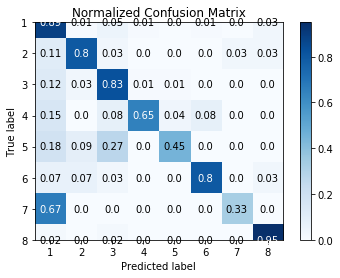

In [50]:
skplt.metrics.plot_confusion_matrix(y_pred=y_pred, y_true=y_test, normalize=True)

In [51]:
pipeline = gs

tag_message(pipeline, 'My alarm clock was not set properly. I come to the office asap.')
tag_message(pipeline, 'It is my scheduled day off, see you on Tuesday.')
tag_message(pipeline, 'Not feeling well today, I stay home and work from here.')
tag_message(pipeline, 'I work at home on Tuesday.')
tag_message(pipeline, 'This morning I have a meeting at SPS.')
tag_message(pipeline, 'I\'m off, see you tomorrow.')
tag_message(pipeline, 'get well soon!')
tag_message(pipeline, 'I\'m away for a long lunch between 12:00 and 15:30')
tag_message(pipeline, 'I\'ve an appointment at 12:00 at the physiotherapy.')

          late/early | My alarm clock was not set properly. I come to the office asap.
            holidays | It is my scheduled day off, see you on Tuesday.
                 ill | Not feeling well today, I stay home and work from here.
         home office | I work at home on Tuesday.
            business | This morning I have a meeting at SPS.
            holidays | I'm off, see you tomorrow.
       miscellanious | get well soon!
          late/early | I'm away for a long lunch between 12:00 and 15:30
             med app | I've an appointment at 12:00 at the physiotherapy.


# 9)- GridSearch with Random Forest

In [0]:
%%time

steps = [('vectorizer', CountVectorizer()),
         ('transformer', TfidfTransformer()),
         ('classifier', RandomForestClassifier())]
pipeline11 = Pipeline(steps)

params = {
    'vectorizer__tokenizer': [None, nltk.tokenize.word_tokenize],
    'vectorizer__analyzer': ['word', stemmed, lemma],
    'vectorizer__stop_words': [None, nltk.corpus.stopwords.words('english'), 'english'],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)],
    'vectorizer__preprocessor': [None, mask_all, mask_integers, mask_times, mask_emojis]
    'classifier__n_estimators': [128, 512, 2048],
    'classifier__bootstrap': [True, False],
    'classifier__criterion': ['gini', 'entropy'], 
    'classifier__max_depth': [2, 4, 8, None],
    'classifier__min_samples_leaf': [1, 3, 10], 
    'classifier__min_samples_split': [2, 8, 16]
}

gs_rf = GridSearchCV(pipeline11, params, n_jobs=-1,verbose=5)
gs_rf.fit(X_train, y_train)

In [0]:
print(gs_rf.best_params_)

In [0]:
y_pred = gs_rf.predict(X_test)

In [0]:
print('Score on the test set: {:.2f}'.format(gs_rf.score(X_test, y_test)))

In [0]:
print(classification_report(y_pred=y_pred, y_true=y_test))

In [0]:
skplt.metrics.plot_confusion_matrix(y_pred=y_pred, y_true=y_test, normalize=True)

# 10)- Test on Out of Sample data

In [0]:
pipeline = gs

tag_message(pipeline, 'My alarm clock was not set properly. I come to the office asap.')
tag_message(pipeline, 'It is my scheduled day off, see you on Tuesday.')
tag_message(pipeline, 'Not feeling well today, I stay home and work from here.')
tag_message(pipeline, 'I work at home on Tuesday.')
tag_message(pipeline, 'This morning I have a meeting at SPS.')
tag_message(pipeline, 'I\'m off, see you tomorrow.')
tag_message(pipeline, 'get well soon!')
tag_message(pipeline, 'I\'m away for a long lunch between 12:00 and 15:30')
tag_message(pipeline, 'I\'ve an appointment at 12:00 at the physiotherapy.')